# Training a PIX2PIX Model using PyTorch / ONNX

This notebook walks you through the steps of training your own image-to-image machine learning model.

Basically all you have to do is put your cursor in a cell and press Shift+Enter. At the end, you can download the latest model from the `output` folder (it will be called something like `generator_epoch_XXX.onnx`).

In [1]:
# Make sure you are connected to a runtime with a GPU
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


In [2]:
# Install ONNX (not installed by default)
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
%pip install -q onnx

/Users/fdb/Projects/2025-raive-workshop/.venv/bin/python3: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import all other dependencies
import glob, os, random, copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
from PIL import Image

import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from types import SimpleNamespace
from IPython.display import clear_output
from torch.nn.utils import spectral_norm
from torch.cuda.amp import autocast, GradScaler

In [4]:
# Check if GPU is available
gpu_available = torch.cuda.is_available()
print("GPU is", "available" if gpu_available else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [ ]:
# Download and unzip the dataset
!curl -O https://algorithmicgaze.s3.amazonaws.com/workshops/2025-raive/patterns_512.zip
mkdir -p datasets/patterns
!unzip -j -o -qq *.zip -d datasets/patterns

In [5]:
# Some helper functions for creating/checking directories.
def directory_should_exist(*args):
    dir = os.path.join(*args)
    if not os.path.isdir(dir):
        raise Exception("Path '{}' is not a directory.".format(dir))
    return dir

def ensure_directory(*args):
    dir = os.path.join(*args)
    os.makedirs(dir, exist_ok=True)
    return dir

In [6]:
# Point to your dataset and configure training
input_dir = directory_should_exist("datasets/patterns_512")
output_dir = ensure_directory("output")

# I/O and schedule
epochs = 100
batch_size = 8              # 512x512 is heavy; tweak based on VRAM
sample_interval = 50        # iterations between samples
snapshot_interval = 1       # epochs between checkpoints

# Latent & image
z_dim = 128
img_channels = 3
image_size = 512

# Optim & regularization (modern defaults for SN+hinge)
g_lr = 2e-4
d_lr = 2e-4
betas = (0.0, 0.99)

# Regularization / stability
d_reg_every = 16           # R1 every N D steps (lazy)
r1_gamma = 10.0            # R1 weight (StyleGAN2 uses 10 at 256; 10 is fine here)
ema_decay = 0.999          # EMA for generator weights
use_amp = True             # mixed precision for speed
torch.backends.cudnn.benchmark = True  # speed-up on constant shapes

In [7]:
# Unconditional image dataset (no splitting)
class UncondImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir)
                            if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [8]:
transform = transforms.Compose([
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # -> [-1, 1]
])

dataset = UncondImageDataset(input_dir, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)

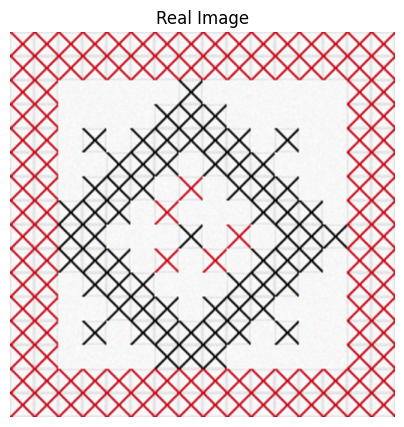

In [9]:
# Show a single real image from the dataset
def plot_image(ax, title, img):
    img = (img + 1) / 2
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())
    ax.set_title(title); ax.axis("off")

assert len(dataset) > 0, f"No images found in {input_dir}. Supported: .jpg .jpeg .png"
real_batch = next(iter(dataloader))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_image(ax, "Real Image", real_batch[0])
plt.show()

In [10]:
# Generator building block: nearest upsample + 3x3 conv + BN + LeakyReLU
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [11]:
class Generator(nn.Module):
    """
    Fast-ish DCGAN-style generator for 512x512.
    Channel schedule favors speed; adjust if you need more fidelity.
    """
    def __init__(self, z_dim=128, img_channels=3, chs=(512, 512, 256, 128, 64, 32, 16)):
        super().__init__()
        self.z_dim = z_dim
        self.chs = chs
        # Map z to 4x4xchs[0]
        self.fc = nn.Linear(z_dim, 4 * 4 * chs[0])
        # Upsampling stack: 4→8→16→...→512
        blocks = []
        for cin, cout in zip(chs[:-1], chs[1:]):
            blocks.append(UpBlock(cin, cout))
        self.up = nn.Sequential(*blocks)
        self.to_rgb = nn.Conv2d(chs[-1], img_channels, kernel_size=1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, z):
        if z.dim() == 2:
            x = self.fc(z).view(-1, self.chs[0], 4, 4)
        else:
            # allow [B, z, 1, 1]
            x = self.fc(z.view(z.size(0), -1)).view(-1, self.chs[0], 4, 4)
        x = self.up(x)
        x = torch.tanh(self.to_rgb(x))
        return x

In [12]:
class Discriminator(nn.Module):
    """
    SN discriminator for 512x512 using strided 4x4 convs.
    Uses global average pooling before the final linear head
    so it adapts to whatever final channel count the body yields.
    """
    def __init__(self, img_channels=3, chs=(64, 128, 256, 512, 512, 512, 512)):
        super().__init__()
        layers = []
        in_ch = img_channels
        for out_ch in chs:
            layers += [
                spectral_norm(nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            in_ch = out_ch

        self.body = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d(1)         # -> [B, C, 1, 1]
        self.head = spectral_norm(nn.Linear(in_ch, 1))  # maps [B, C] -> [B, 1]

    def forward(self, x):
        h = self.body(x)                 # [B, C, H, W]
        h = self.pool(h).view(h.size(0), -1)  # [B, C]
        logits = self.head(h).squeeze(1) # [B]
        return logits

In [13]:
# --- Training helpers: R1, EMA, Hinge losses ---

def r1_penalty(d_out, real_img):
    # ∇_x D(x) on real images
    grads = torch.autograd.grad(
        outputs=d_out.sum(), inputs=real_img,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    return grads.pow(2).reshape(grads.size(0), -1).sum(dim=1).mean()

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = copy.deepcopy(model).eval()
        for p in self.shadow.parameters():
            p.requires_grad = False

    @torch.no_grad()
    def update(self, model):
        msd = self.shadow.state_dict()
        for k, src in model.state_dict().items():
            tgt = msd[k]
            # Only blend floating-point tensors; copy others (e.g., integer buffers)
            if torch.is_floating_point(tgt):
                # tgt = decay * tgt + (1 - decay) * src
                tgt.mul_(self.decay).add_(src, alpha=1.0 - self.decay)
            else:
                tgt.copy_(src)

# Hinge loss:
#   D:  E[max(0, 1 - D(real))] + E[max(0, 1 + D(fake))]
#   G: -E[D(fake)]

In [14]:
# Load snapshot if available
def get_latest_snapshot(output_dir):
    snapshots = glob.glob(os.path.join(output_dir, "snapshot_epoch_*.pth"))
    if not snapshots:
        return None
    return max(snapshots, key=os.path.getctime)

def get_latest_generator(output_dir):
    generators = glob.glob(os.path.join(output_dir, "generator_epoch_*.onnx"))
    if not generators:
        return None
    return max(generators, key=os.path.getctime)

In [15]:
def load_snapshot(generator, discriminator, g_optimizer, d_optimizer, snapshot_path, ema_shadow=None):
    checkpoint = torch.load(snapshot_path, map_location=device, weights_only=False)
    generator.load_state_dict(checkpoint["generator"])
    discriminator.load_state_dict(checkpoint["discriminator"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer"])
    if ema_shadow is not None and "ema_generator" in checkpoint:
        ema_shadow.load_state_dict(checkpoint["ema_generator"])
    start_epoch = int(os.path.basename(snapshot_path).split("_")[2].split(".")[0])
    return start_epoch

In [16]:
# Create the training loop (unconditional GAN, hinge + R1, SN-D, EMA, AMP)
def train(generator, discriminator, dataloader, opts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.train().to(device)
    discriminator.train().to(device)

    g_opt = optim.Adam(generator.parameters(), lr=opts.g_lr, betas=opts.betas)
    d_opt = optim.Adam(discriminator.parameters(), lr=opts.d_lr, betas=opts.betas)

    scaler_g = GradScaler(enabled=opts.use_amp)
    scaler_d = GradScaler(enabled=opts.use_amp)

    ema = EMA(generator, decay=opts.ema_decay)

    # Fixed latent for monitoring
    fixed_z = torch.randn(16, opts.z_dim, device=device)

    start_epoch = 1
    if not getattr(opts, "restart", False):
        latest_snapshot = get_latest_snapshot(opts.output_dir)
        if latest_snapshot:
            start_epoch = load_snapshot(
                generator, discriminator, g_opt, d_opt, latest_snapshot, ema_shadow=ema.shadow
            )
            print(f"Resumed from {latest_snapshot} (start_epoch={start_epoch})")

    it = 0
    for epoch in range(start_epoch, opts.epochs + 1):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{opts.epochs}")
        for real in pbar:
            it += 1
            real = real.to(device, non_blocking=True)
            bsz = real.size(0)

            # -----------------------
            #  Train Discriminator
            # -----------------------
            z = torch.randn(bsz, opts.z_dim, device=device)
            with autocast(enabled=opts.use_amp):
                with torch.no_grad():
                    fake = generator(z)
                d_real = discriminator(real)
                d_fake = discriminator(fake)
                d_loss = F.relu(1.0 - d_real).mean() + F.relu(1.0 + d_fake).mean()

            d_opt.zero_grad(set_to_none=True)
            scaler_d.scale(d_loss).backward()
            scaler_d.step(d_opt)
            scaler_d.update()

            # Lazy R1 regularization on real images
            if (it % opts.d_reg_every) == 0:
                real_req = real.detach().requires_grad_(True)
                # Compute R1 in FP32 for stability
                with autocast(enabled=False):
                    d_real_r1 = discriminator(real_req.float())
                    r1 = r1_penalty(d_real_r1, real_req.float())
                    r1_loss = (opts.r1_gamma / 2.0) * r1
                d_opt.zero_grad(set_to_none=True)
                scaler_d.scale(r1_loss).backward()
                scaler_d.step(d_opt)
                scaler_d.update()

            # -----------------------
            #  Train Generator
            # -----------------------
            z = torch.randn(bsz, opts.z_dim, device=device)
            with autocast(enabled=opts.use_amp):
                fake = generator(z)
                g_fake = discriminator(fake)
                g_loss = -g_fake.mean()

            g_opt.zero_grad(set_to_none=True)
            scaler_g.scale(g_loss).backward()
            scaler_g.step(g_opt)
            scaler_g.update()

            # EMA update
            ema.update(generator)

            pbar.set_postfix({
                "D": f"{d_loss.item():.3f}",
                "G": f"{g_loss.item():.3f}",
            })

            # Visualization and sampling
            if it % opts.sample_interval == 0:
                with torch.no_grad():
                    generator.eval()
                    samples = ema.shadow(fixed_z).detach().cpu()
                    # Save and show
                    save_path = os.path.join(opts.output_dir, f"epoch_{epoch}_iter_{it}.jpg")
                    save_image(samples, save_path, nrow=4, normalize=True, value_range=(-1, 1))
                    clear_output(wait=True)
                    print(f"Epoch {epoch} | iter {it}")
                    grid = (samples[:4] + 1) / 2
                    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
                    for a, img in zip(axes, grid):
                        a.imshow(img.permute(1, 2, 0).numpy()); a.axis("off")
                    plt.show()
                    generator.train()

        # Snapshot & ONNX export at epoch end
        if (epoch % opts.snapshot_interval) == 0:
            snap_path = os.path.join(opts.output_dir, f"snapshot_epoch_{epoch}.pth")
            torch.save({
                "generator": generator.state_dict(),
                "discriminator": discriminator.state_dict(),
                "g_optimizer": g_opt.state_dict(),
                "d_optimizer": d_opt.state_dict(),
                "ema_generator": ema.shadow.state_dict(),
            }, snap_path)
            print(f"Saved snapshot to {snap_path}")

            # Export ONNX from EMA generator (better inference)
            ema.shadow.eval()
            dummy_z = torch.randn(1, opts.z_dim, device=device)
            traced = torch.jit.trace(ema.shadow, dummy_z)
            onnx_path = os.path.join(opts.output_dir, f"generator_epoch_{epoch}.onnx")
            torch.onnx.export(
                traced,
                dummy_z,
                onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=["z"],
                output_names=["image"],
                dynamic_axes={"z": {0: "batch"}, "image": {0: "batch"}},
            )
            print(f"ONNX model exported to {onnx_path}")
            ema.shadow.train()

Epoch 4 | iter 450


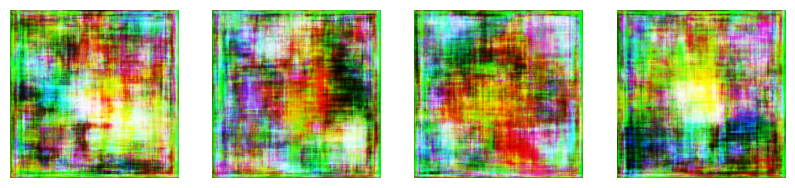

Epoch 4/100:  61%|█████████████████████████████████████████▉                           | 76/125 [02:10<01:24,  1.72s/it, D=0.000, G=1.667]


KeyboardInterrupt: 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim=z_dim, img_channels=img_channels).to(device)
discriminator = Discriminator(img_channels=img_channels).to(device)

opts = SimpleNamespace(
    output_dir=output_dir,
    sample_interval=sample_interval,
    snapshot_interval=snapshot_interval,
    epochs=epochs,
    restart=False,
    # new:
    z_dim=z_dim,
    g_lr=g_lr, d_lr=d_lr, betas=betas,
    d_reg_every=d_reg_every, r1_gamma=r1_gamma,
    ema_decay=ema_decay, use_amp=use_amp,
)

train(generator, discriminator, dataloader, opts)

## Optional: Copy the generator model to Google Drive

You can save some time downloading/uploading the generator by using Google Drive. In the next steps we'll connect to Google Drive and upload the generator. The conversion Colab notebook will look for this zip file and convert it.

In [ ]:
# Step 1: Mount Google Drive. This will ask for permissions.
from google.colab import drive
drive.mount('/drive')

In [ ]:
# Step 2: Copy the generator.zip to Google Drive
import shutil
drive_folder = '/drive/MyDrive/2025-raive'
ensure_directory(drive_folder)
shutil.copy(get_latest_generator(output_dir), drive_folder)